# Feature Analysis

This framework is used to analyse the audio signals (spoken words), usch that good features can be extracted to cluster them. 

# Imports

In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd
from tqdm import tqdm
# Math
import numpy as np
import scipy.stats
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
import librosa.display
from scipy import sparse, stats, spatial
import scipy.sparse.linalg

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd
import pygsp

%matplotlib inline

plt.rcParams['figure.figsize'] = (17, 5)
pygsp.plotting.BACKEND = 'matplotlib'

2018-01-08 18:19:01,488:[WARNING](pygsp.graphs.nngraphs.nngraph.<module>): Cannot import pyflann (used for faster kNN computations): Traceback (most recent call last):
  File "C:\Users\Manuel\Anaconda3\lib\site-packages\pygsp\graphs\nngraphs\nngraph.py", line 14, in <module>
    import pyflann as pfl
  File "C:\Users\Manuel\Anaconda3\lib\site-packages\pyflann\__init__.py", line 27, in <module>
    from pyflann.index import *
  File "C:\Users\Manuel\Anaconda3\lib\site-packages\pyflann\index.py", line 27, in <module>
    from pyflann.bindings.flann_ctypes import *
  File "C:\Users\Manuel\Anaconda3\lib\site-packages\pyflann\bindings\__init__.py", line 30, in <module>
    from pyflann.bindings.flann_ctypes import *
  File "C:\Users\Manuel\Anaconda3\lib\site-packages\pyflann\bindings\flann_ctypes.py", line 171, in <module>
    raise ImportError('Cannot load dynamic library. Did you compile FLANN?')
ImportError: Cannot load dynamic library. Did you compile FLANN?



## 1. Import the Data
----
Use `N` random samples for each word.

In [2]:
N = 2

train_audio_path = '../Data/train/audio'
dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]
dirs.sort()

path = []
word = []
speaker = []
iteration = []

for direct in dirs:
    if not direct.startswith('_'):
        # Random selection of N files per folder 
        list_files = os.listdir(join(train_audio_path, direct))
        wave_selected  = list(np.random.choice([ f for f in list_files if f.endswith('.wav')],N,replace=False))
        
        # Extraction of file informations for dataframe
        word.extend(list(np.repeat(direct,N,axis=0)))
        speaker.extend([wave_selected[f].split('.')[0].split('_')[0] for f in range(N) ])
        iteration.extend([wave_selected[f].split('.')[0].split('_')[-1] for f in range(N) ])
        path.extend([train_audio_path + '/' + direct + '/' + wave_selected[f] for f in range(N)])

Initialize the dataframe of the original data

In [3]:
features_og = pd.DataFrame({('info','word',''): word,
                            ('info','speaker',''): speaker,
                            ('info','iteration',''): iteration,
                            ('info','path',''): path})
index_og = [('info','word',''),('info','speaker',''),('info','iteration','')]
#features_og.set_index(index_og,inplace=True)
features_og.head()

info                                                                
  iteration                                            path   speaker  word
                                                                           
0         1   ../Data/train/audio/bed/a2473d62_nohash_1.wav  a2473d62   bed
1         0   ../Data/train/audio/bed/cc71bada_nohash_0.wav  cc71bada   bed
2         1  ../Data/train/audio/bird/129c7d8d_nohash_1.wav  129c7d8d  bird
3         2  ../Data/train/audio/bird/dbb7723a_nohash_2.wav  dbb7723a  bird
4         0   ../Data/train/audio/cat/b36c27c2_nohash_0.wav  b36c27c2   cat

## 2. Features Extraction
----
### 2.1 MFCC
A classical but reliable set of features

In [4]:
N_MFCC = 20

def compute_mfcc(filepath):
    audio, sampling_rate = librosa.load(filepath, sr=None, mono=True)
    return librosa.feature.mfcc(y=audio,sr=sampling_rate)

In [5]:
stat_name= ['mean','std','skew','kurtosis','median']
col_names = [('mfcc',stat_name[i],j) for i in range(len(stat_name))  for j in range(N_MFCC)]
features_mfcc =pd.DataFrame(columns=pd.MultiIndex.from_tuples(col_names),index=features_og.index)
# sorting the columns in order to improve index performances (see lexsort errors)
features_mfcc.sort_index(axis=1,inplace=True,sort_remaining=True)

# MFCC FEATURES :
for w in tqdm(range(len(features_og)),total=len(features_og),unit='waves'):
    mfcc = compute_mfcc(features_og[('info','path')].iloc[w])
    features_mfcc.loc[w, ('mfcc', 'mean')] = np.mean(mfcc,axis=1)
    features_mfcc.loc[w, ('mfcc', 'std')] = np.std(mfcc,axis=1)
    features_mfcc.loc[w, ('mfcc', 'skew')] = scipy.stats.skew(mfcc,axis=1)
    features_mfcc.loc[w, ('mfcc', 'kurtosis')] = scipy.stats.kurtosis(mfcc,axis=1)
    features_mfcc.loc[w, ('mfcc', 'median')] = np.median(mfcc,axis=1)
    
features_og = features_og.merge(features_mfcc,left_index=True,right_index=True)
features_og.head()

100%|██████████| 60/60 [00:03<00:00, 17.55waves/s]


info                                                                  \
  iteration                                            path   speaker  word   
                                                                              
0         1   ../Data/train/audio/bed/a2473d62_nohash_1.wav  a2473d62   bed   
1         0   ../Data/train/audio/bed/cc71bada_nohash_0.wav  cc71bada   bed   
2         1  ../Data/train/audio/bird/129c7d8d_nohash_1.wav  129c7d8d  bird   
3         2  ../Data/train/audio/bird/dbb7723a_nohash_2.wav  dbb7723a  bird   
4         0   ../Data/train/audio/cat/b36c27c2_nohash_0.wav  b36c27c2   cat   

       mfcc                                                     ...     \
   kurtosis                                                     ...      
          0         1         2         3         4         5   ...      
0  0.491323 -0.199797  0.515545 -0.548525   1.10534 -0.205176   ...      
1 -0.692605  0.980157 -0.636927  -1.34052  0.671656 -0.675807   ...      
2  -1.80327  -1.79623  0.861768  -1.53477  0.226914  -1.74563   ...      
3 -0.031653 -0.593419 -0.377559  0.717748 -0.109385 -0.123186   ...      
4  -1.06201  0.371366   0.86484  0.503747  0.290852  -0.26494   ...      

                                                                           \
       std                                                                  
        10       11       12       13       14       15       16       17   
0  4.94451  5.79488  5.96624  5.75483  10.3323  3.91498  3.32249  3.79052   
1  8.32454  8.64334  3.61384   5.0187  5.03758  7.30635  4.10912  6.58877   
2  8.84364  10.2334  6.67595  6.14921  8.50488  5.06693  6.54145  4.88264   
3   12.566   6.7637  5.84399  5.36199   7.3727  7.67449  8.56091  7.71394   
4  7.73437  6.58698  8.38718  5.35832   5.7886  8.79103  3.58584  5.33544   

                     
                     
        18       19  
0  3.16798  3.93043  
1  16.3742  4.45486  
2  9.72212  4.51992  
3  5.77029    7.162  
4  4.62688  4.67756  

[5 rows x 104 columns]

## Signal Analysis

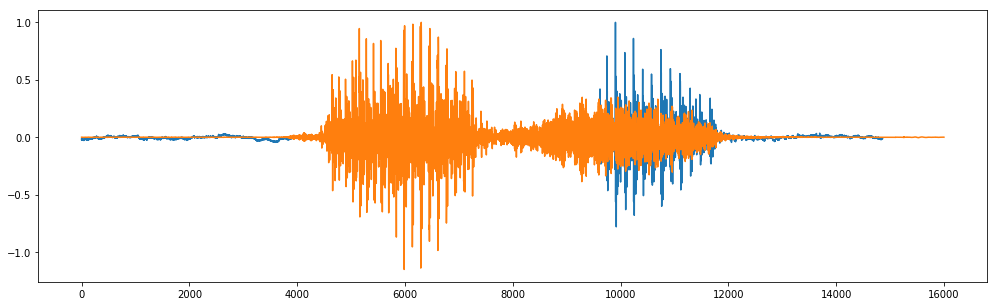

In [166]:
word_1 = 0
word_2 = 20
def get_audio(filepath):
    audio, sampling_rate = librosa.load(filepath, sr=None, mono=True)
    return audio, sampling_rate

audio_1, sampling_rate_1 = get_audio(features_og[('info','path')].iloc[word_1])
audio_2, sampling_rate_2 = get_audio(features_og[('info','path')].iloc[word_2])

# normalize audio signals
audio_1 = audio_1/np.max(audio_1)
audio_2  = audio_2/np.max(audio_2)

# Look at the signal in the time domain
plt.plot(audio_1)
plt.hold
plt.plot(audio_2)

# Listen to the first word
ipd.Audio(data=audio_1, rate=sampling_rate_1)

In [167]:
# Listen to second word
ipd.Audio(data=audio_2, rate=sampling_rate_2)

## From audio signal to distance 

### Extract word from sound file

In [168]:
def find_lobes(Thresh, audio, shift = int(2048/16)):
    """Finds all energy lobes in an audio signal and returns their start and end indices. The parameter Thresh defines
       the sensitivity of the algforithm."""
    # Compute rmse
    audio = audio/np.max(audio)
    rmse_audio = librosa.feature.rmse(audio, hop_length = 1, frame_length=int(shift*2)).reshape(-1,)
    rmse_audio -= np.min(rmse_audio)
    rmse_audio /= np.max(rmse_audio)
    i_start = np.array([])
    i_end = np.array([])
    for i in range(len(rmse_audio)-1):
        if (int(rmse_audio[i]>Thresh)-int(rmse_audio[i+1]>Thresh)) == -1:
            i_start = np.append(i_start,i)
        elif (int(rmse_audio[i]>Thresh)-int(rmse_audio[i+1]>Thresh)) == 1:    
            i_end = np.append(i_end,i)
    
    if len(i_start) == 0:
        i_start = np.append(i_start,0)
        
    if len(i_end) == 0:
        i_end = np.append(i_end,i)   
    
    if i_start[0]>i_end[0]:
        i_start = np.append(np.array(0), i_start)
        
    if i_start[-1]>i_end[-1]:
        i_end = np.append(i_end,i)
    
    return i_start, i_end, rmse_audio, shift

In [169]:
def cut_signal( audio, Thresh = 0.1, mode = 'proxy',reach = 2000, number_lobes = 2):
    """Extracts relevant parts ofn audio signal.
       The Thresh input value defines the sensitivity of the cut, its value has to be positive.
       Two modes can be chosen:
           - proxy(Default): Finds main energy lobe of the signal and also adds lobes that are within reach. 
                             The reach parameter can be adjusted adn has to be a positive value (default is 2000.)
           - num_lobes:      Finds the highest energy lobes of the signal. The parameter num_lobes (default value 2) 
                             defines how many of the largest lobes are being considered. """
    
    i_start, i_end, rmse_audio, shift = find_lobes(Thresh, audio)
    energy = np.array([])
    for i in range(len(i_start)):
        energy = np.append(energy,sum(rmse_audio[int(i_start[i]):int(i_end[i])]))
    
    if mode is 'num_lobes':
        lobes = np.argsort(energy)[-number_lobes:]
        start = np.min(i_start[lobes])
        end = np.max(i_end[lobes])
    elif mode is 'proxy':
        main_lobe = np.argsort(energy)[-1]
        start = i_start[main_lobe]
        end = i_end[main_lobe]
        for i in range(main_lobe):
            if (i_start[main_lobe]-i_end[i])<reach:
                start = np.min((i_start[i],start))
                
        for i in range(main_lobe,len(i_start)):   
            if (i_start[i]-i_end[main_lobe])<reach:
                end = i_end[i]
        
    else:
        print('ERROR: mode not implemented.')
    
        
    audio_cut = audio[int(np.max((0,int(start-shift-300)))):int(np.min((int(end)+300,len(audio))))]    
    return audio_cut

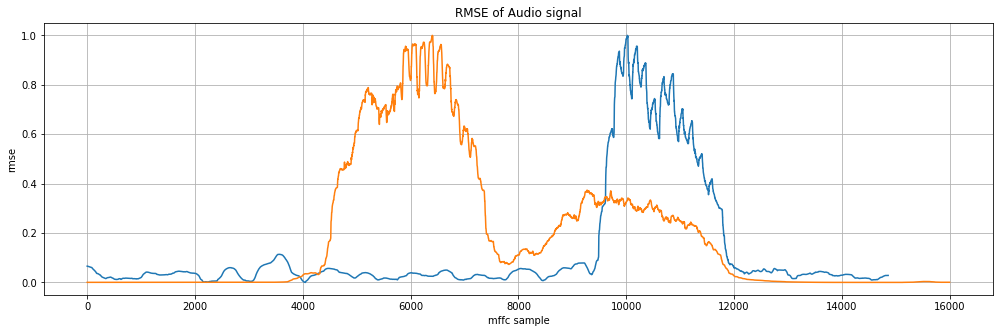

In [170]:
rmse_audio_1 = librosa.feature.rmse(audio_1, hop_length = 1, frame_length=int(2048/8)).reshape(-1,)
rmse_audio_1 -= np.min(rmse_audio_1) 
rmse_audio_1 /= np.max(rmse_audio_1)
plt.plot(rmse_audio_1)
plt.grid()
plt.title('RMSE of Audio signal')
plt.xlabel('mffc sample')
plt.ylabel('rmse')
plt.hold
rmse_audio_2 = librosa.feature.rmse(audio_2, hop_length = 1,  frame_length=int(2048/8)).reshape(-1,)
rmse_audio_2 -= np.min(rmse_audio_2) 
rmse_audio_2 /= np.max(rmse_audio_2)
plt.plot(rmse_audio_2)

(8056,)


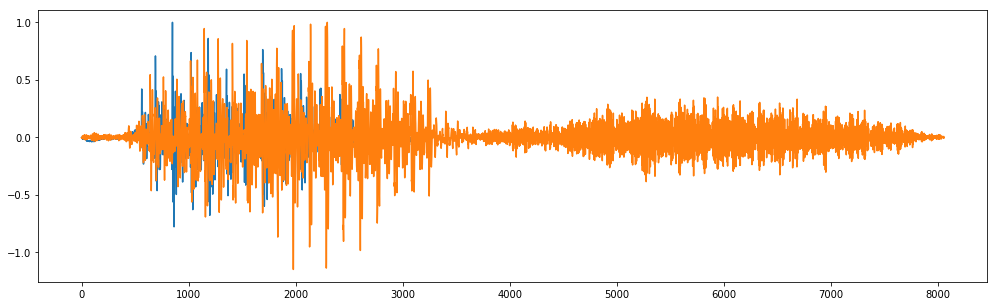

In [171]:
# just keep stuff above threshold
Thresh = 0.01

audio_1_cut = cut_signal(audio_1)

audio_2_cut = cut_signal(audio_2)

print(np.shape(audio_2_cut))
# Display cut time signal
plt.plot(audio_1_cut)
plt.hold
plt.plot(audio_2_cut)
ipd.Audio(data=audio_1_cut, rate=sampling_rate_1)

In [172]:
ipd.Audio(data=audio_2_cut, rate=sampling_rate_2)

## Features

In [195]:
N_MFCCS = 10
#n_fft, hop_length
mfccs_1 = librosa.feature.mfcc(y=audio_1_cut,sr=sampling_rate_1, n_mfcc=N_MFCCS, n_fft = int(2048/2), hop_length = int(np.floor(len(audio_1_cut)/20)))
mfccs_2 = librosa.feature.mfcc(y=audio_2_cut,sr=sampling_rate_2, n_mfcc=N_MFCCS, n_fft = int(2048/2), hop_length = int(np.floor(len(audio_2_cut)/20)))
mfccs_1 = mfccs_1[:,:-1]
mfccs_2 = mfccs_2[:,:-1]
print(np.shape(mfccs_1))
print(np.shape(mfccs_2))

(10, 20)
(10, 20)


17.2412834604
